In [1]:
!pip install grad-cam
!pip install pytorch_lightning
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  U

In [2]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
import cv2
import numpy as np
import torchvision
import torch
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.image as img
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.classification import F1Score
from lightning.pytorch import seed_everything
from sklearn.model_selection import train_test_split
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
import torch.optim as optim

In [3]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/BT5153_FinalProject'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/BT5153_FinalProject
/content/gdrive/.shortcut-targets-by-id/1E1Y94YFrnEb-mWKsVJpBhTngD-Kqv3FZ/BT5153_FinalProject


# Load EfficientNet Model

In [4]:
# Define constants
BATCH_SIZE = 32
IMG_SIZE = 224  # EfficientNet in torchvision uses 224 as the default size
EPOCHS = 10
DATASET_PATH = "/content/gdrive/My Drive/BT5153_FinalProject/Dataset2/Train"
SAVE_PATH = "/content/gdrive/My Drive/BT5153_FinalProject/EfficientNetbestmodel"


# Load EfficientNet
model = models.efficientnet_b0(pretrained=True)

num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)


data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization parameters for ImageNet
])

full_dataset = datasets.ImageFolder(root=DATASET_PATH, transform=data_transforms)

train_size = int(0.75 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 114MB/s] 


In [5]:
# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
best_val_loss = float('inf')
device

device(type='cuda')

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    global best_val_loss
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f'Epoch {epoch+1}, Train Loss: {total_loss / len(train_loader)}, Val Loss: {val_loss}')

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_path = f'{SAVE_PATH}/best_model_eff.pth'
            torch.save(model.state_dict(), save_path)
            print("Saved Best Model")

train_model(model, criterion, optimizer, EPOCHS)

Epoch 1, Train Loss: 0.020874711920029498, Val Loss: 0.018699778883039413
Epoch 2, Train Loss: 0.01009827378276226, Val Loss: 0.01367574435232288
Epoch 3, Train Loss: 0.0030384552566984284, Val Loss: 0.01202925929162795
Epoch 4, Train Loss: 0.018643039891925343, Val Loss: 0.008166228893734966
Saved Best Model
Epoch 5, Train Loss: 0.0010591809078095548, Val Loss: 0.0016702376582719398
Saved Best Model
Epoch 6, Train Loss: 0.00030468181578171524, Val Loss: 0.0008186761184267579
Saved Best Model
Epoch 7, Train Loss: 0.0032452060608902885, Val Loss: 0.007388599545136333
Epoch 8, Train Loss: 0.008917533565656393, Val Loss: 0.016992216911720818
Epoch 9, Train Loss: 0.011866097923852426, Val Loss: 0.09885549278072675


In [6]:
from sklearn.metrics import f1_score
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b0(pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, 2)  # Modify for 2 classes

model.load_state_dict(torch.load('/content/gdrive/My Drive/BT5153_FinalProject/EfficientNetbestmodel/best_model_eff.pth'))  # Load your best model
model = model.to(device)
model.eval()
transformations = transforms.Compose([
    transforms.Resize((224, 224)),  # Match the input size that the model expects
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization used during training
])

data_path = "/content/gdrive/My Drive/BT5153_FinalProject/Dataset2/Test"
subtypes = ['sea', 'buildings', 'forest', 'glacier', 'mountain', 'street']
results = {}

for subtype in subtypes:
    path = f"{data_path}/{subtype}"
    dataset = datasets.ImageFolder(root=path, transform=transformations)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute F1 score and other statistics
    f1 = f1_score(all_labels, all_preds, average='weighted')
    report = classification_report(all_labels, all_preds, target_names=dataset.classes)
    results[subtype] = {
        "F1 Score": f1,
        "Report": report
    }
    print(f"F1 Score for {subtype}: {f1}")
    print(report)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


F1 Score for sea: 1.0
              precision    recall  f1-score   support

          AI       1.00      1.00      1.00        60
        Real       1.00      1.00      1.00       102

    accuracy                           1.00       162
   macro avg       1.00      1.00      1.00       162
weighted avg       1.00      1.00      1.00       162

F1 Score for buildings: 1.0
              precision    recall  f1-score   support

          AI       1.00      1.00      1.00        62
        Real       1.00      1.00      1.00        86

    accuracy                           1.00       148
   macro avg       1.00      1.00      1.00       148
weighted avg       1.00      1.00      1.00       148

F1 Score for forest: 1.0
              precision    recall  f1-score   support

          AI       1.00      1.00      1.00        61
        Real       1.00      1.00      1.00        94

    accuracy                           1.00       155
   macro avg       1.00      1.00      1.00       155

# Data preparing for Grad-CAM

In [11]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, environment=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.environment = environment
        environment_to_id = {
            'buildings': 0,
            'forest': 1,
            'glacier': 2,
            'mountain': 3,
            'sea': 4,
            'street': 5
        }

        categories = ['AI', 'Real']
        for category in categories:
            category_path = os.path.join(root_dir, category)
            for env in os.listdir(category_path):
                if environment is not None and env != environment:
                    continue  # Skip other environments if a specific one is set
                environment_path = os.path.join(category_path, env)
                if not os.path.isdir(environment_path):
                    continue
                for image_name in os.listdir(environment_path):
                    image_path = os.path.join(environment_path, image_name)
                    if os.path.isfile(image_path) and image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                        self.image_paths.append(image_path)
                        self.labels.append(0 if category == 'AI' else 1)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label


In [8]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [12]:
root_dir = '/content/gdrive/My Drive/BT5153_FinalProject/Dataset'
environments = ['street', 'buildings', 'forest', 'glacier', 'mountain', 'sea']
dataloaders = {}

for env in environments:
    dataset = ImageDataset(root_dir, transform=transform, environment=env)
    dataloaders[env] = DataLoader(dataset, batch_size=6, shuffle=True)


dataloader_buildings = dataloaders['buildings']
dataloader_forest = dataloaders['forest']
dataloader_glacier = dataloaders['glacier']
dataloader_mountain = dataloaders['mountain']
dataloader_sea = dataloaders['sea']
dataloader_street = dataloaders['street']

# Grad-CAM

In [14]:
# Prepare Grad-CAM
target_layers = [model.features[-1]]  # Use the last convolutional layer
cam = GradCAM(model=model, target_layers=target_layers)


# Model error testing

In [ ]:
# labled 0 and predicted 1
root_dir = '/content/gdrive/My Drive/BT5153_FinalProject/Dataset'
dataset = ImageDataset(root_dir, transform=transform, environment=None)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

plt.figure(figsize=(15, 6))  # Adjust size as needed

# Collecting images
collected_images = []
collected_labels = []
collected_predictions = []
count = 0  # To keep track of how many images we have collected

for images, labels in dataloader:
    if count >= 6:
        break  # Stop if we have collected enough images
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    predictions = outputs.argmax(dim=1)

    for img, label, prediction in zip(images, labels, predictions):
        if label.item() == 0 and prediction.item() == 1:
            collected_images.append(img.cpu())
            collected_labels.append(label.item())
            collected_predictions.append(prediction.item())
            count += 1
            if count == 6:
                break

# Generating and displaying Grad-CAM heatmaps
for i, img in enumerate(collected_images):
    img = img.unsqueeze(0).to(device)
    output = model(img)

    # Generate CAM heatmap
    grayscale_cam = cam(input_tensor=img)
    grayscale_cam = grayscale_cam[0, :]
    img_cpu = img.squeeze().numpy().transpose(1, 2, 0)
    cam_image = show_cam_on_image(img_cpu, grayscale_cam, use_rgb=True)

    # Plot original image
    plt.subplot(2, 6, i + 1)
    plt.imshow(img_cpu)
    plt.title(f'Label: {collected_labels[i]}, Pred: {collected_predictions[i]}')
    plt.axis('off')

    # Plot CAM image
    plt.subplot(2, 6, i + 7)
    plt.imshow(cam_image)
    plt.title('Grad-CAM')
    plt.axis('off')

plt.tight_layout()
plt.show()

<Figure size 1500x600 with 0 Axes>

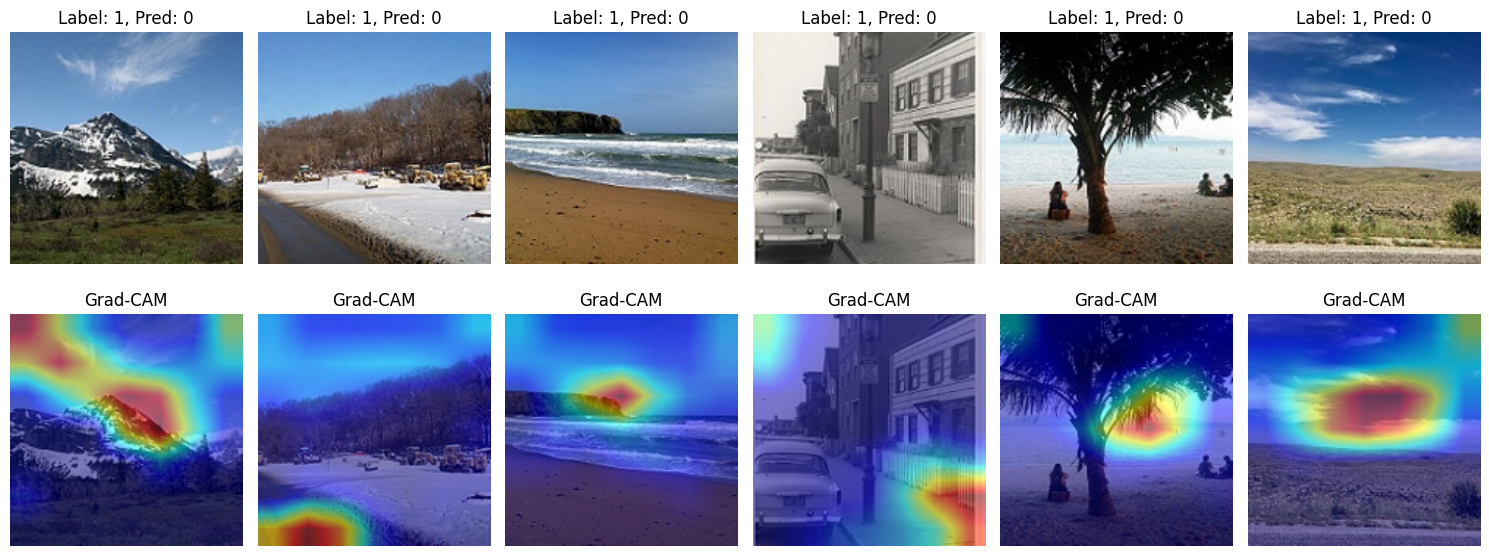

In [ ]:
# labled 1 and predicted 0
root_dir = '/content/gdrive/My Drive/BT5153_FinalProject/Dataset'
dataset = ImageDataset(root_dir, transform=transform, environment=None)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

plt.figure(figsize=(15, 6))  # Adjust size as needed

# Collecting images
collected_images = []
collected_labels = []
collected_predictions = []
count = 0  # To keep track of how many images we have collected

for images, labels in dataloader:
    if count >= 6:
        break  # Stop if we have collected enough images
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    predictions = outputs.argmax(dim=1)

    for img, label, prediction in zip(images, labels, predictions):
        if label.item() == 1 and prediction.item() == 0:
            collected_images.append(img.cpu())
            collected_labels.append(label.item())
            collected_predictions.append(prediction.item())
            count += 1
            if count == 6:
                break

# Generating and displaying Grad-CAM heatmaps
for i, img in enumerate(collected_images):
    img = img.unsqueeze(0).to(device)
    output = model(img)

    # Generate CAM heatmap
    grayscale_cam = cam(input_tensor=img)
    grayscale_cam = grayscale_cam[0, :]
    img_cpu = img.squeeze().cpu().numpy().transpose(1, 2, 0)
    cam_image = show_cam_on_image(img_cpu, grayscale_cam, use_rgb=True)

    # Plot original image
    plt.subplot(2, 6, i + 1)
    plt.imshow(img_cpu)
    plt.title(f'Label: {collected_labels[i]}, Pred: {collected_predictions[i]}')
    plt.axis('off')

    # Plot CAM image
    plt.subplot(2, 6, i + 7)
    plt.imshow(cam_image)
    plt.title('Grad-CAM')
    plt.axis('off')

plt.tight_layout()
plt.show()

### street dataset

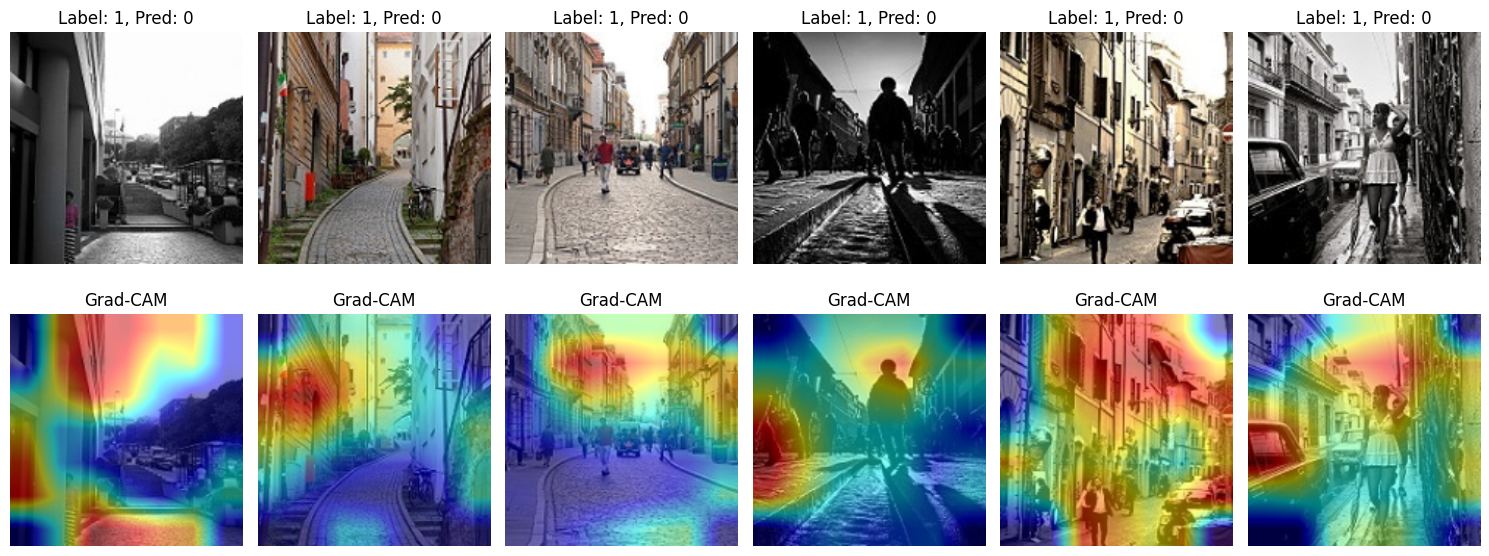

In [16]:
# labled 1 and predicted 0

plt.figure(figsize=(15, 6))  # Adjust size as needed

# Collecting images
collected_images = []
collected_labels = []
collected_predictions = []
count = 0  # To keep track of how many images we have collected

for images, labels in dataloader_street:
    if count >= 6:
        break  # Stop if we have collected enough images
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    predictions = outputs.argmax(dim=1)

    for img, label, prediction in zip(images, labels, predictions):
        if label.item() == 1 and prediction.item() == 0:
            collected_images.append(img.cpu())
            collected_labels.append(label.item())
            collected_predictions.append(prediction.item())
            count += 1
            if count == 6:
                break

# Generating and displaying Grad-CAM heatmaps
for i, img in enumerate(collected_images):
    img = img.unsqueeze(0).to(device)
    output = model(img)

    # Generate CAM heatmap
    grayscale_cam = cam(input_tensor=img)
    grayscale_cam = grayscale_cam[0, :]
    img_cpu = img.squeeze().cpu().numpy().transpose(1, 2, 0)
    cam_image = show_cam_on_image(img_cpu, grayscale_cam, use_rgb=True)

    # Plot original image
    plt.subplot(2, 6, i + 1)
    plt.imshow(img_cpu)
    plt.title(f'Label: {collected_labels[i]}, Pred: {collected_predictions[i]}')
    plt.axis('off')

    # Plot CAM image
    plt.subplot(2, 6, i + 7)
    plt.imshow(cam_image)
    plt.title('Grad-CAM')
    plt.axis('off')

plt.tight_layout()
plt.show()

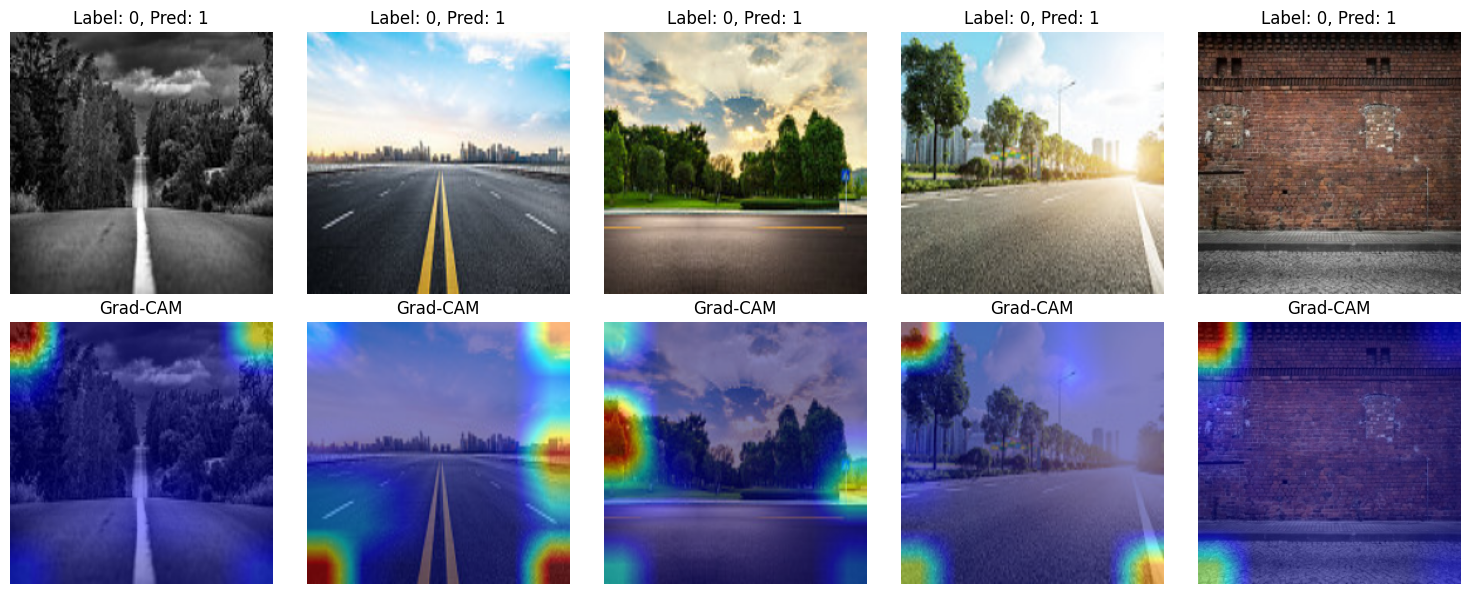

In [18]:
# labled 0 and predicted 1

plt.figure(figsize=(15, 6))  # Adjust size as needed

# Collecting images
collected_images = []
collected_labels = []
collected_predictions = []
count = 0  # To keep track of how many images we have collected

for images, labels in dataloader_street:
    if count >= 5:
        break  # Stop if we have collected enough images
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    predictions = outputs.argmax(dim=1)

    for img, label, prediction in zip(images, labels, predictions):
        if label.item() == 0 and prediction.item() == 1:
            collected_images.append(img.cpu())
            collected_labels.append(label.item())
            collected_predictions.append(prediction.item())
            count += 1
            if count == 5:
                break

# Generating and displaying Grad-CAM heatmaps
for i, img in enumerate(collected_images):
    img = img.unsqueeze(0).to(device)
    output = model(img)

    # Generate CAM heatmap
    grayscale_cam = cam(input_tensor=img)
    grayscale_cam = grayscale_cam[0, :]
    img_cpu = img.squeeze().cpu().numpy().transpose(1, 2, 0)
    cam_image = show_cam_on_image(img_cpu, grayscale_cam, use_rgb=True)

    # Plot original image
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_cpu)
    plt.title(f'Label: {collected_labels[i]}, Pred: {collected_predictions[i]}')
    plt.axis('off')

    # Plot CAM image
    plt.subplot(2, 5, i + 6)
    plt.imshow(cam_image)
    plt.title('Grad-CAM')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Different layer

In [ ]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
#on the last layer
target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)
dataloaders = [
    (dataloader_street, "Street"),
    (dataloader_buildings, "Buildings"),
    (dataloader_forest, "Forest"),
    (dataloader_glacier, "Glacier"),
    (dataloader_mountain, "Mountain"),
    (dataloader_sea, "Sea")
]

plt.figure(figsize=(24,36))

# Iterate over environments
for env_index, (dataloader, env_name) in enumerate(dataloaders):
    images, labels = next(iter(dataloader))  # Get a batch from each environment

    for i in range(6):
        img = images[i].unsqueeze(0).to(device)  # Prepare image
        output = model(img)
        prediction = output.argmax(dim=1)

        # Generate CAM heatmap
        grayscale_cam = cam(input_tensor=img)
        grayscale_cam = grayscale_cam[0, :]
        img_cpu = img.squeeze().cpu().numpy().transpose(1, 2, 0)
        cam_image = show_cam_on_image(img_cpu, grayscale_cam, use_rgb=True)

        # Plot each CAM image in a subplot
        plt.subplot(6, 6, env_index * 6 + i + 1)  # Calculate the subplot position
        plt.imshow(cam_image)
        plt.title(f'{env_name} - Label: {labels[i].item()}, Pred: {prediction.item()}')
        plt.axis('off')

# Show the plot after adding all subplots
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#on the second last layer

target_layers = [model.features[-3][-1]]
cam = GradCAM(model=model, target_layers=target_layers)

dataloaders = [
    (dataloader_street, "Street"),
    (dataloader_buildings, "Buildings"),
    (dataloader_forest, "Forest"),
    (dataloader_glacier, "Glacier"),
    (dataloader_mountain, "Mountain"),
    (dataloader_sea, "Sea")
]

plt.figure(figsize=(24,36))

# Iterate over environments
for env_index, (dataloader, env_name) in enumerate(dataloaders):
    images, labels = next(iter(dataloader))  # Get a batch from each environment

    for i in range(6):
        img = images[i].unsqueeze(0).to(device)  # Prepare image
        output = model(img)
        prediction = output.argmax(dim=1)

        # Generate CAM heatmap
        grayscale_cam = cam(input_tensor=img)
        grayscale_cam = grayscale_cam[0, :]
        img_cpu = img.squeeze().cpu().numpy().transpose(1, 2, 0)
        cam_image = show_cam_on_image(img_cpu, grayscale_cam, use_rgb=True)

        # Plot each CAM image in a subplot
        plt.subplot(6, 6, env_index * 6 + i + 1)  # Calculate the subplot position
        plt.imshow(cam_image)
        plt.title(f'{env_name} - Label: {labels[i].item()}, Pred: {prediction.item()}')
        plt.axis('off')

# Show the plot after adding all subplots
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Compare different models:ResNet50 & EfficientNet

In [5]:
environment_to_id = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}
class BinaryClassificationResNet50(pl.LightningModule):
    def __init__(self, num_classes=2, learning_rate=1e-3):
        super(BinaryClassificationResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_ftrs, num_classes)

        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()
        # Define F1 score metric for each phase
        self.train_f1 = F1Score(task='binary', average='macro')
        self.val_f1 = F1Score(task='binary', average='macro')
        self.test_f1 = F1Score(task='binary', average='macro')
        #self.training_step_outputs = []
        #self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, x):
        return self.resnet50(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        inputs, labels = batch[:2]
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        self.train_f1.update(preds, labels)
        # Log loss and F1 directly here, letting PL handle averaging
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        train_f1_score = self.train_f1.compute()  # Computes current value of F1
        self.log('train_f1', train_f1_score, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.train_f1.reset()  # Reset F1 after logging to avoid accumulation over batches
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch[:2]
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        self.val_f1.update(preds, labels)
        # Directly log loss and F1
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        val_f1_score = self.val_f1.compute()
        self.log('val_f1', val_f1_score, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.val_f1.reset()

    def test_step(self, batch, batch_idx):
        inputs, labels, env_labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        self.test_f1.update(preds, labels)
        self.test_step_outputs.append ({'loss': loss, 'test_preds': preds, 'test_labels': labels, 'env_labels': env_labels})

    def on_test_epoch_end(self):
        # Aggregate the losses
        losses = torch.stack([x['loss'] for x in self.test_step_outputs])
        avg_loss = torch.mean(losses)
        self.log('test_loss', avg_loss, on_epoch=True, prog_bar=True, logger=True)

        # Compute and log the F1 score for validation
        test_f1_score = self.test_f1.compute()  # Compute the F1 score
        self.log('test_f1', test_f1_score, on_epoch=True, prog_bar=True, logger=True)

        # Concatenate all predictions, labels, and environment labels from each batch
        all_preds = torch.cat([x['test_preds'] for x in self.test_step_outputs], dim=0)
        all_labels = torch.cat([x['test_labels'] for x in self.test_step_outputs], dim=0)
        all_envs = torch.cat([x['env_labels'] for x in self.test_step_outputs], dim=0)

        # Convert to CPU and to numpy arrays for use with sklearn metrics
        all_preds = all_preds.cpu().numpy()
        all_labels = all_labels.cpu().numpy()
        all_envs = all_envs.cpu().numpy()

        # Reverse the mapping from environment ID to name
        id_to_environment = {v: k for k, v in environment_to_id.items()}

        # Iterate over each environment and compute the classification report
        for env_id, env_name in id_to_environment.items():
            env_mask = (all_envs == env_id)
            env_labels = all_labels[env_mask]
            env_preds = all_preds[env_mask]

            # Compute the classification report for this environment
            report = classification_report(env_labels, env_preds, output_dict=True)

            # Print the classification report
            print(f'Environment: {env_name}\n', classification_report(env_labels, env_preds))
        self.test_f1.reset()
        self.test_step_outputs.clear()

In [7]:
model2 = BinaryClassificationResNet50()

# Load the pretrained weights from the checkpoint
checkpoint_path = 'model_checkpoints/best_model_2-v1.ckpt'
checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))
model2.load_state_dict(checkpoint['state_dict'])

# Transfer model to GPU if available
model2 = model2.to('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
root_dir = '/content/gdrive/My Drive/BT5153_FinalProject/Comparison dataset'
environments = ['street', 'buildings', 'forest', 'glacier', 'mountain', 'sea']
dataloaders = {}

for env in environments:
    dataset = ImageDataset(root_dir, transform=transforms, environment=env)
    dataloaders[env] = DataLoader(dataset, batch_size=6, shuffle=True)


dataloader_buildings = dataloaders['buildings']
dataloader_forest = dataloaders['forest']
dataloader_glacier = dataloaders['glacier']
dataloader_mountain = dataloaders['mountain']
dataloader_sea = dataloaders['sea']
dataloader_street = dataloaders['street']

In [8]:
transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

In [ ]:
# Prepare for Grad-CAM
target_layers = [model2.resnet50.layer4[-1]]  # last layer
cam = GradCAM(model=model2, target_layers=target_layers)

dataloaders = [
    (dataloader_street, "Street"),
    (dataloader_buildings, "Buildings"),
    (dataloader_forest, "Forest"),
    (dataloader_glacier, "Glacier"),
    (dataloader_mountain, "Mountain"),
    (dataloader_sea, "Sea")
]

model2.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Start a new figure
plt.figure(figsize=(24, 36))

# Iterate over environments
for env_index, (dataloader, env_name) in enumerate(dataloaders):
    images, labels = next(iter(dataloader))  # Get a batch from each environment

    for i in range(6):
        img = images[i].unsqueeze(0).to(device)  # Prepare image
        output = model2(img)
        prediction = output.argmax(dim=1)

        # Generate CAM heatmap
        grayscale_cam = cam(input_tensor=img)
        grayscale_cam = grayscale_cam[0, :]
        img_cpu = img.squeeze().cpu().numpy().transpose(1, 2, 0)
        cam_image = show_cam_on_image(img_cpu, grayscale_cam, use_rgb=True)

        # Plot each CAM image in a subplot
        plt.subplot(6, 6, env_index * 6 + i + 1)  # Calculate the subplot position
        plt.imshow(cam_image)
        plt.title(f'{env_name} - Label: {labels[i].item()}, Pred: {prediction.item()}')
        plt.axis('off')

# Show the plot after adding all subplots
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [12]:
# find images that ResNet50 makes wrong prediction on
from torchvision.utils import save_image

save_path = '/content/gdrive/My Drive/BT5153_FinalProject/errordata'
os.makedirs(save_path, exist_ok=True)

model2.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device)

# Data loading
root_dir = '/content/gdrive/My Drive/BT5153_FinalProject/Dataset'
dataset = ImageDataset(root_dir, transform=transforms, environment=None)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize counter for saved images
saved_images_count = 0

# Process images
with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        _, preds = torch.max(outputs, 1)

        # Filter images where prediction is 0 but label is 1
        mismatches = (preds == 0) & (labels == 1)

        # Save the mismatched images
        for i in range(len(images)):
            if mismatches[i]:
                img_path = os.path.join(save_path, f'error_{saved_images_count + 1}.png')
                save_image(images[i].cpu(), img_path)
                saved_images_count += 1
                if saved_images_count >= 15:
                    break
        if saved_images_count >= 15:
            break



In [15]:
target_layers = [model2.resnet50.layer4[-1]]  # last layer
cam = GradCAM(model=model2, target_layers=target_layers)

save_path = '/content/gdrive/My Drive/BT5153_FinalProject/errordata'
images_files = os.listdir(save_path)

plt.figure(figsize=(24, 36))


for index, image_file in enumerate(images_files):
    image_path = os.path.join(save_path, image_file)
    image = Image.open(image_path).convert('RGB')
    image_tensor = transforms(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model2(image_tensor)
        _, predicted = torch.max(output, 1)

    # Grad-CAM
    grayscale_cam = cam(input_tensor=image_tensor)
    grayscale_cam = grayscale_cam[0, :]
    img_cpu = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    cam_image = show_cam_on_image(img_cpu, grayscale_cam, use_rgb=True)

    # Plotting
    plt.subplot(6, 6, index + 1)  # This assumes a grid layout that needs to be adjusted based on image count
    plt.imshow(cam_image)
    plt.title(f'Predicted: {predicted.item()}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [9]:
# EfficientNet
target_layers = [model.features[-1]]  # last layer
cam = GradCAM(model=model, target_layers=target_layers)

save_path = '/content/gdrive/My Drive/BT5153_FinalProject/errordata'
images_files = os.listdir(save_path)

plt.figure(figsize=(24, 36))


for index, image_file in enumerate(images_files):
    image_path = os.path.join(save_path, image_file)
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    # Grad-CAM
    grayscale_cam = cam(input_tensor=image_tensor)
    grayscale_cam = grayscale_cam[0, :]
    img_cpu = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    cam_image = show_cam_on_image(img_cpu, grayscale_cam, use_rgb=True)

    # Plotting
    plt.subplot(6, 6, index + 1)  # This assumes a grid layout that needs to be adjusted based on image count
    plt.imshow(cam_image)
    plt.title(f'Predicted: {predicted.item()}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.